<a href="https://colab.research.google.com/github/kenken0830/Graphing/blob/main/DreamBooth_SD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

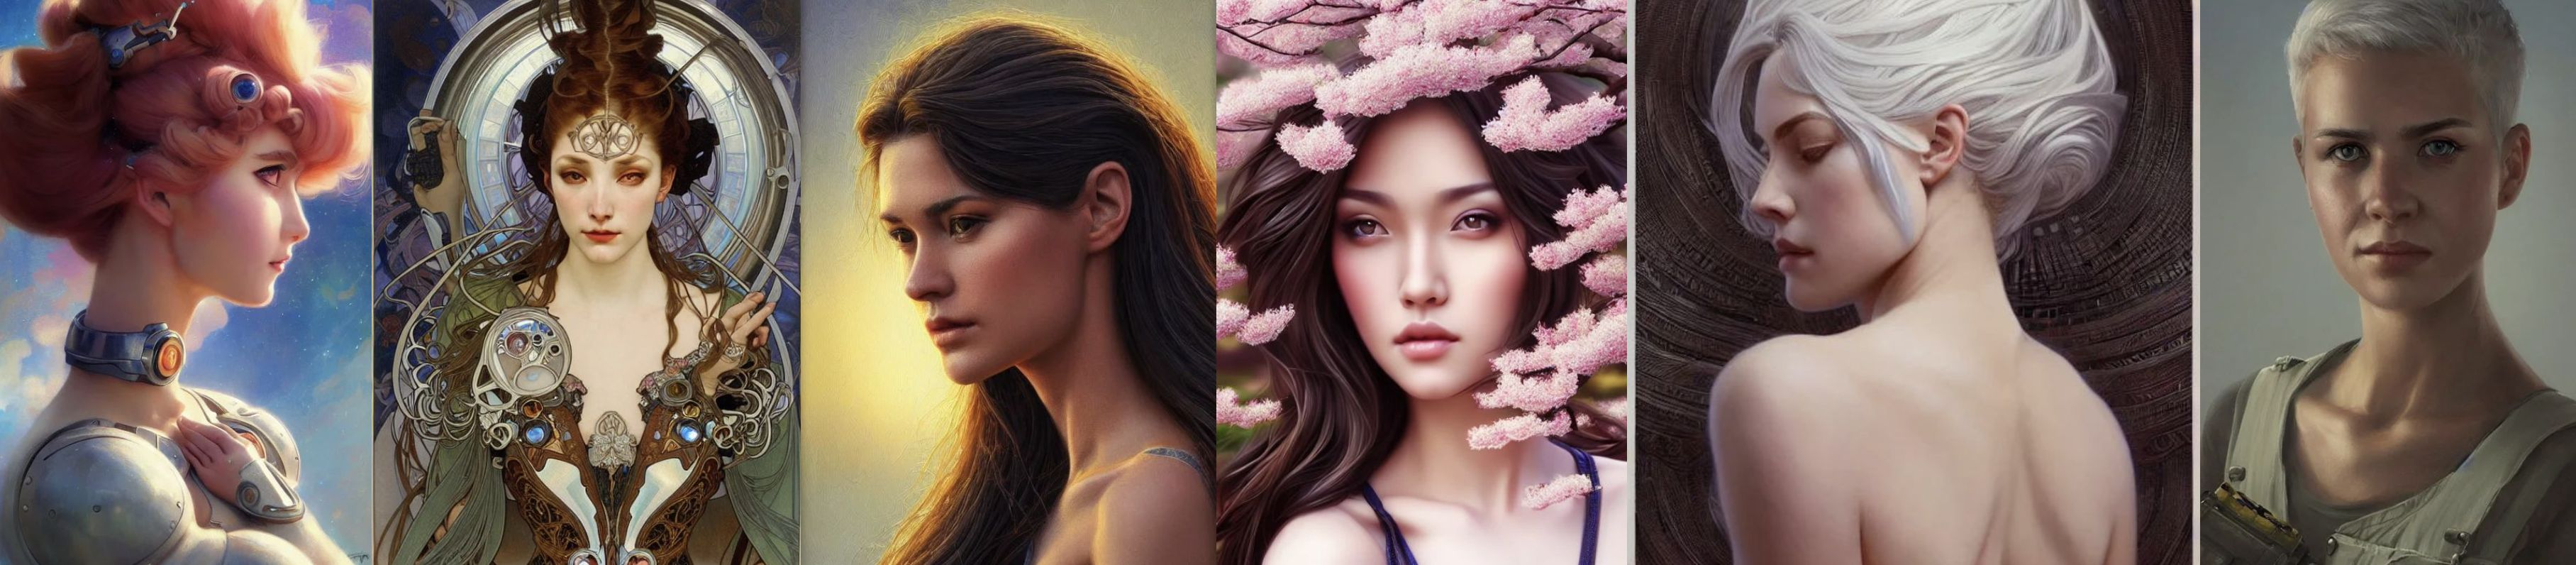

In [1]:
#@title #**install dreambooth**
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate==0.12.0 transformers ftfy bitsandbytes gradio


Tesla T4, 15109 MiB, 15109 MiB
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163 kB 5.0 MB/s 
     |████████████████████████████████| 18.7 MB 62 kB/s 
     |████████████████████████████████| 143 kB 5.1 MB/s 
     |████████████████████████████████| 5.3 MB 42.3 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 62.5 MB 1.2 MB/s 
     |████████████████████████████████| 11.6 MB 55.6 MB/s 
     |████████████████████████████████| 7.6 MB 54.2 MB/s 
     |████████████████████████████████| 212 kB 72.4 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 2.3 MB 48.4 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 272 kB 58.3 MB/s 
     |████████████████████████████████| 55 kB 4.2 MB/s 
     |████████████████████████████████| 5

In [2]:
#@title #**login to HuggingFace**

#@markdown You need to accept the model license before downloading or using the Stable Diffusion weights. Please, visit the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work.
from huggingface_hub import notebook_login
!git config --global credential.helper store
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [3]:
#@title #**install xformers**

%pip install -q https://github.com/metrolobo/xformers_wheels/releases/download/1d31a3ac_various_6/xformers-0.0.14.dev0-cp37-cp37m-linux_x86_64.whl
# These were compiled on Tesla T4, should also work on P100, thanks to https://github.com/metrolobo

# If precompiled wheels don't work, install it with the following command. It will take around 40 minutes to compile.
# %pip install git+https://github.com/facebookresearch/xformers@1d31a3a#egg=xformers

     |████████████████████████████████| 102.9 MB 89 kB/s 


In [3]:
#@title #**setting folder**

# define function
import os
import shutil
def reset_folder(path):
    if os.path.isdir(path):
      shutil.rmtree(path)
    os.makedirs(path,exist_ok=True)

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import glob
def display_pic(folder):
    fig = plt.figure(figsize=(30, 60))
    files = sorted(glob.glob(folder+'/*.jpg'))
    for i, file in enumerate(files):
        img = Image.open(file)    
        images = np.asarray(img)
        ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        name = os.path.basename(file)
        ax.set_xlabel(name, fontsize=30)  
        fig.tight_layout()             
    plt.show()
    plt.close()

# setting
MODEL_NAME = "CompVis/stable-diffusion-v1-4" 

INSTANCE = "kasumiarimura"#@param {type:"string"}
INSTANCE_DIR = "/content/data/"+INSTANCE 
reset_folder(INSTANCE_DIR)

CLASS = "portrait" #@param {type:"string"}
CLASS_DIR = "/content/data/"+CLASS
reset_folder(CLASS_DIR)

OUTPUT_DIR = "/content/stable_diffusion_weights/" + INSTANCE
reset_folder(OUTPUT_DIR)


Downloading...
From: https://drive.google.com/uc?id=1NqdBzYndW5mAm21MlOC6uP6gH61lWWZ5
To: /content/kasumi.zip
100%|██████████| 138k/138k [00:00<00:00, 49.3MB/s]

Archive:  kasumi.zip
  inflating: /content/data/kasumiarimura/05.jpg  
  inflating: /content/data/kasumiarimura/01.jpg  
  inflating: /content/data/kasumiarimura/02.jpg  
  inflating: /content/data/kasumiarimura/03.jpg  
  inflating: /content/data/kasumiarimura/04.jpg  


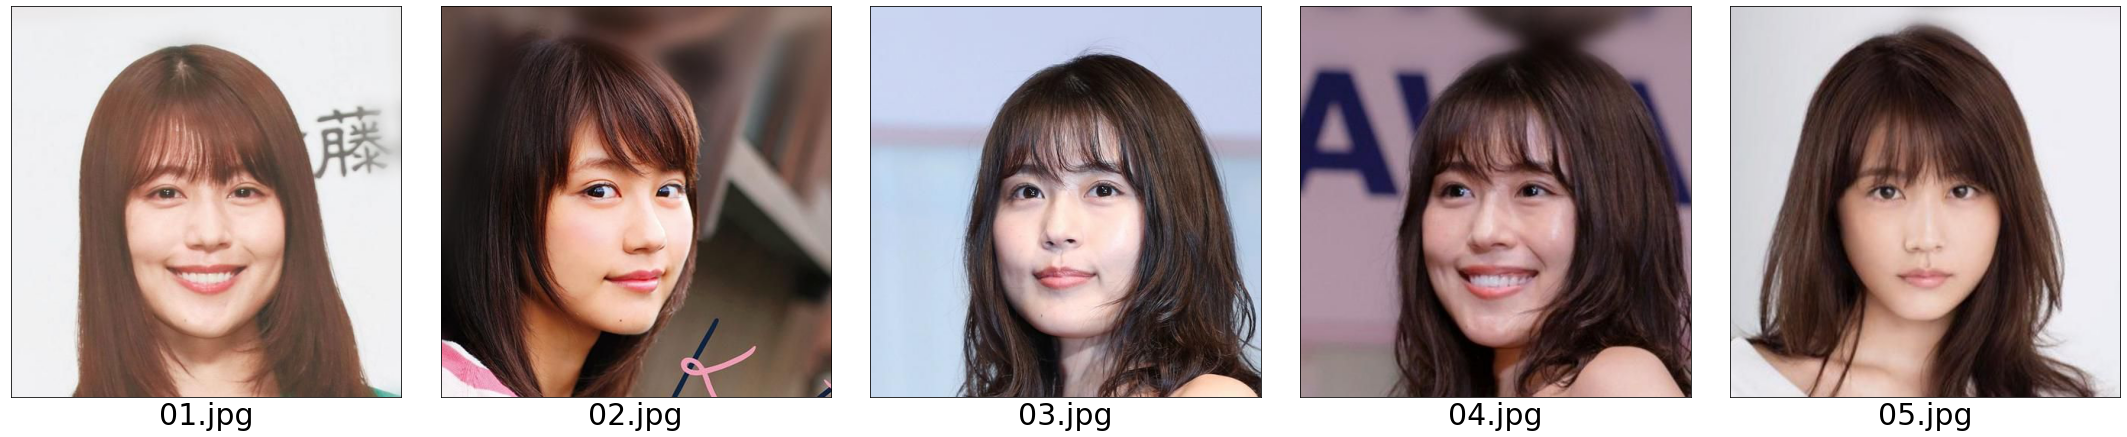

In [4]:
#@title #**upload pics**
import os
from google.colab import files
import shutil
import gdown

sample_pics = True #@param {type:"boolean"}
if sample_pics:
  gdown.download('https://drive.google.com/uc?id=1NqdBzYndW5mAm21MlOC6uP6gH61lWWZ5', 'kasumi.zip', quiet=False)
  ! unzip -d $INSTANCE_DIR kasumi.zip
else:
  uploaded = files.upload()
  for filename in uploaded.keys():
      dst_path = os.path.join(INSTANCE_DIR, filename)
      shutil.move(filename, dst_path)

%matplotlib inline
display_pic(INSTANCE_DIR)

In [5]:
#@title #**train** (takes 20〜30minutes)

!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt=$INSTANCE \
  --class_prompt=$CLASS\
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=800 \
  --save_interval=10_000 \
  --save_sample_prompt=$CLASS


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--num_cpu_threads_per_process` was set to `1` to improve out-of-box performance
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
[!] Not using xformers memory efficient attention.
Downloading: 100% 335M/335M [00:04<00:00, 68.7MB/s]
Downloading: 100% 547/547 [00:00<00:00, 659kB/s]
Downloading: 100% 543/543 [00:00<00:00, 455kB/s]
Fetching 16 files:   0% 0/16 [00:00<?, ?it/s]
Downloading: 100% 342/342 [00:00<00:00, 294kB/s]
Fetching 16 files:   6% 1/16 [00:01<00:15,  1.03s/it]
Downloading: 100% 4.56k/4.56k [00:00<00:00, 2.79MB/s]
Fetching 16 files:  19% 3/16 [00:02<00:08,  1.56it/s]
Downloading:   0% 0.00/1.22G [00:00<?, ?B/s]
Downloading:   0% 3.22M/1.22G [00:00<00:37, 32.2MB/s]
Downloading:   1% 7.37M/1.2

In [6]:
#@title #**make pipe for generating images**

# Specify the weights directory to use (leave blank for latest)
WEIGHTS_DIR = "" 
if WEIGHTS_DIR == "":
    from natsort import natsorted
    from glob import glob
    import os
    WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR.rstrip(os.sep)+"/*"))[-1]

# Inference
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = StableDiffusionPipeline.from_pretrained(model_path, scheduler=scheduler, safety_checker=None, torch_dtype=torch.float16).to("cuda")

g_cuda = None

# seed setting
g_cuda = torch.Generator(device='cuda')
seed = 52362 #@param {type:"number"}
g_cuda.manual_seed(seed)

[!] Not using xformers memory efficient attention.


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

OSError: ignored

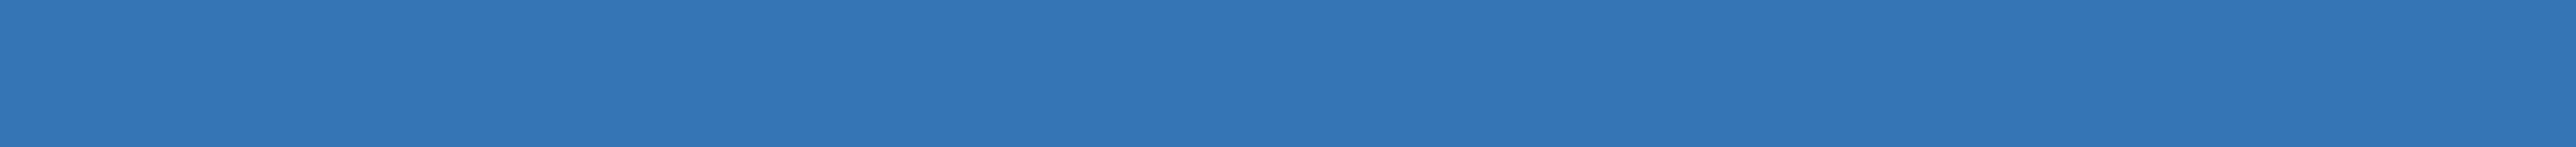

In [ ]:
#@title #**manual generat images**

reset_folder('images')

# prompt
prompt = "kasumiarimura portrait" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}

# other setting
num_samples = 10 
guidance_scale = 7.5 
num_inference_steps = 50 
height = 512 
width = 512 

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for i, img in enumerate(images):
    img.save('images/'+str(i).zfill(4)+'.jpg')
    display(img)

In [ ]:
#@title #**Download images**
from google.colab import files
 
if os.path.isfile('data.zip'):
  os.remove('data.zip')
 
! zip -r data.zip images
files.download('data.zip')

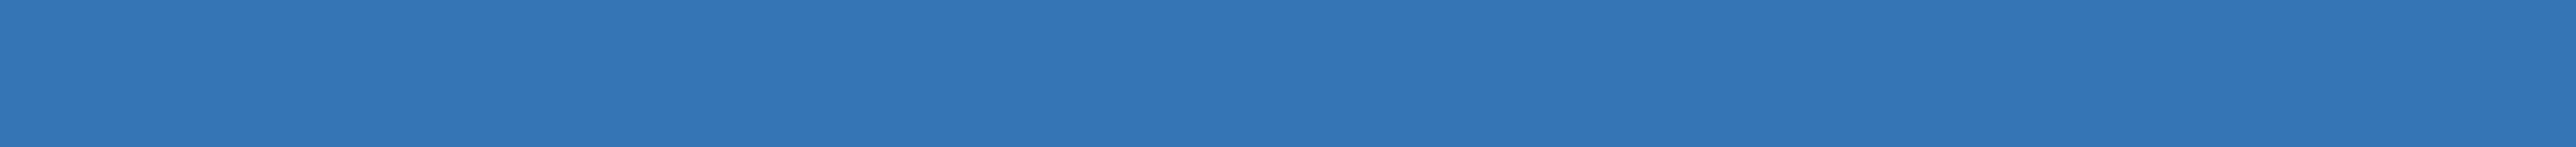

In [ ]:
#@title #**auto generat images**

# prompt bank
p0 = 'XXX profile picture by margaret keane, dynamic pose, intricate, futuristic, fantasy, elegant, by stanley artgerm lau, greg rutkowski, thomas kindkade, alphonse mucha, loish, norman rockwell'
p1 = 'Realistic detailed face portrait of a beautiful futuristic italian renaissance queen in opulent alien glass armor by alphonse mucha, XXX, ayami kojima, amano, greg hildebrandt, and mark brooks, female, feminine, art nouveau, ornate italian renaissance cyberpunk, iridescent venetian blown glass, neo - gothic, gothic, character concept design'
p2 = 'Photo of a gorgeous XXX in the style of stefan kostic, realistic, sharp focus, 8 k high definition, insanely detailed, intricate, elegant, art by david cronenberg and stanley lau and artgerm'
p3 = 'Photo of a gorgeous female in the style of stefan kostic, XXX, realistic, half body shot, sharp focus, 8 k high definition, insanely detailed, intricate, elegant, art by stanley lau and artgerm, extreme blur cherry blossoms background'
p4 = 'God and goddess, XXX, white hair, long hair, gorgeous, amazing, elegant, intricate, highly detailed, digital painting, artstation, concept art, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha'
p5 = 'Portrait of a military engineer woman with short white hair, XXX, wearing overalls, medium shot, portrait, concept art, natural lighting, illustration, full color, highly detailed, photorealistic, by greg rutkowski, artstation'
bank = [p0, p1, p2, p3, p4, p5]

reset_folder('images')

# prompt
name = INSTANCE+' '+CLASS
prompt_bank_No = 0 #@param {type:"slider", min:0, max:5, step:1}
incantation = bank[prompt_bank_No]
prompt = incantation.replace('XXX', name)
print('prompt = ', prompt)
negative_prompt = ""

# other setting
num_samples = 10 
guidance_scale = 7.5 
num_inference_steps = 50 
height = 512 
width = 512 

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for i, img in enumerate(images):
    img.save('images/'+str(i).zfill(4)+'.jpg')
    display(img)

In [ ]:
#@title #**Download images**
from google.colab import files
 
if os.path.isfile('data.zip'):
  os.remove('data.zip')
 
! zip -r data.zip images
files.download('data.zip')